In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import tensorflow as tf
tf.VERSION

'1.15.0'

In [22]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
import sys
import numpy as np
import os

# Input shape
img_rows = 256
img_cols = 256
channels = 3
img_shape = (img_rows, img_cols, channels)

# Calculate output shape of D (PatchGAN)
patch = int(img_rows / 2**4)
disc_patch = (patch, patch, 1)

#Optimizer
optimizer = Adam(0.0002, 0.5)

def Generator():
  """Generator foloows U-Net Architecture"""

  # Image input
  inputs = Input(shape=img_shape)

  # Downsampling
  conv1 = Conv2D(filters=64, kernel_size=4, strides=2, padding='same')(inputs)
  conv1 = LeakyReLU(alpha=0.2)(conv1)

  conv2 = Conv2D(filters=128, kernel_size=4, strides=2, padding='same')(conv1)
  conv2 = LeakyReLU(alpha=0.2)(conv2)
  conv2 = BatchNormalization(momentum=0.8)(conv2)

  conv3 = Conv2D(filters=256, kernel_size=4, strides=2, padding='same')(conv2)
  conv3 = LeakyReLU(alpha=0.2)(conv3)
  conv3 = BatchNormalization(momentum=0.8)(conv3)

  conv4 = Conv2D(filters=512, kernel_size=4, strides=2, padding='same')(conv3)
  conv4 = LeakyReLU(alpha=0.2)(conv4)
  conv4 = BatchNormalization(momentum=0.8)(conv4)

  conv5 = Conv2D(filters=512, kernel_size=4, strides=2, padding='same')(conv4)
  conv5 = LeakyReLU(alpha=0.2)(conv5)
  conv5 = BatchNormalization(momentum=0.8)(conv5)

  conv6 = Conv2D(filters=512, kernel_size=4, strides=2, padding='same')(conv5)
  conv6 = LeakyReLU(alpha=0.2)(conv6)
  conv6 = BatchNormalization(momentum=0.8)(conv6)

  conv7 = Conv2D(filters=512, kernel_size=4, strides=2, padding='same')(conv6)
  conv7 = LeakyReLU(alpha=0.2)(conv7)
  conv7 = BatchNormalization(momentum=0.8)(conv7)
  
  # Upsampling
  deconv1 = UpSampling2D(size=2)(conv7)
  deconv1 = Conv2D(filters=512, kernel_size=4, strides=1, padding='same', activation='relu')(deconv1)
  deconv1 = BatchNormalization(momentum=0.8)(deconv1)
  deconv1 = Concatenate()([deconv1, conv6])

  deconv2 = UpSampling2D(size=2)(deconv1)
  deconv2 = Conv2D(filters=512, kernel_size=4, strides=1, padding='same', activation='relu')(deconv2)
  deconv2 = BatchNormalization(momentum=0.8)(deconv2)
  deconv2 = Concatenate()([deconv2, conv5])

  deconv3 = UpSampling2D(size=2)(deconv2)
  deconv3 = Conv2D(filters=512, kernel_size=4, strides=1, padding='same', activation='relu')(deconv3)
  deconv3 = BatchNormalization(momentum=0.8)(deconv3)
  deconv3 = Concatenate()([deconv3, conv4])

  deconv4 = UpSampling2D(size=2)(deconv3)
  deconv4 = Conv2D(filters=256, kernel_size=4, strides=1, padding='same', activation='relu')(deconv4)
  deconv4 = BatchNormalization(momentum=0.8)(deconv4)
  deconv4 = Concatenate()([deconv4, conv3])

  deconv5 = UpSampling2D(size=2)(deconv4)
  deconv5 = Conv2D(filters=128, kernel_size=4, strides=1, padding='same', activation='relu')(deconv5)
  deconv5 = BatchNormalization(momentum=0.8)(deconv5)
  deconv5 = Concatenate()([deconv5, conv2])

  deconv6 = UpSampling2D(size=2)(deconv5)
  deconv6 = Conv2D(filters=64, kernel_size=4, strides=1, padding='same', activation='relu')(deconv6)
  deconv6 = BatchNormalization(momentum=0.8)(deconv6)
  deconv6 = Concatenate()([deconv6, conv1])

  deconv7 = UpSampling2D(size=2)(deconv6)
  outputs = Conv2D(channels, kernel_size=4, strides=1, padding='same', activation='tanh')(deconv7)

  return Model(inputs = inputs, outputs = outputs)


def Discriminator():
  img_A = Input(shape=img_shape)
  img_B = Input(shape=img_shape)

  # Concatenate image and conditioning image by channels to produce input
  combined_imgs = Concatenate(axis=-1)([img_A, img_B])
  outputs = Conv2D(filters=64, kernel_size=4, strides=2, padding='same')(combined_imgs)
  outputs = LeakyReLU(alpha=0.2)(outputs)

  outputs = Conv2D(filters=128, kernel_size=4, strides=2, padding='same')(outputs)
  outputs = LeakyReLU(alpha=0.2)(outputs)
  outputs = BatchNormalization(momentum=0.8)(outputs)

  outputs = Conv2D(filters=256, kernel_size=4, strides=2, padding='same')(outputs)
  outputs = LeakyReLU(alpha=0.2)(outputs)
  outputs = BatchNormalization(momentum=0.8)(outputs)

  outputs = Conv2D(filters=512, kernel_size=4, strides=2, padding='same')(outputs)
  outputs = LeakyReLU(alpha=0.2)(outputs)
  outputs = BatchNormalization(momentum=0.8)(outputs)
  
  outputs = Conv2D(1, kernel_size=4, strides=1, padding='same')(outputs)

  return Model(inputs = [img_A, img_B], outputs = outputs)

# Build and compile the discriminator
D = Discriminator()
D.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
print(D.summary())
#-------------------------
# Construct Computational
#   Graph of Generator
#-------------------------

# Build the generator
G = Generator()
print(G.summary())

# Input images and their conditioning images
img_A = Input(shape=img_shape)
img_B = Input(shape=img_shape)

# By conditioning on B generate a fake version of A
fake_A = G(img_B)

# For the combined model we will only train the generator
D.trainable = False

# Discriminators determines validity of translated images / condition pairs
valid = D([fake_A, img_B])

combined = Model(inputs=[img_A, img_B], outputs=[valid, fake_A])
combined.compile(loss=['mse', 'mae'], loss_weights=[1, 100], optimizer=optimizer)


Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
concatenate_15 (Concatenate)    (None, 256, 256, 6)  0           input_11[0][0]                   
                                                                 input_12[0][0]                   
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 128, 128, 64) 6208        concatenate_15[0][0]       

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


 Epoch: 1/200 | Batch 400/400 | D-loss: 0.3057 | D-acc: 59% | G-loss: 29.065 | time: 0:00:54.806575

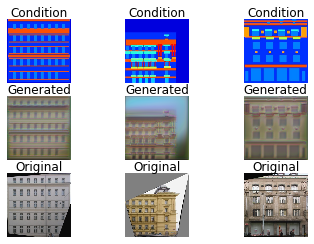

 Epoch: 2/200 | Batch 400/400 | D-loss: 0.0960 | D-acc: 90% | G-loss: 36.296 | time: 0:01:41.247148

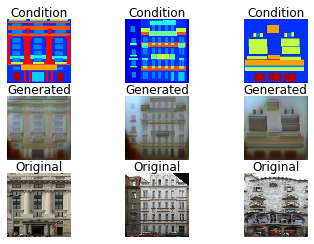

 Epoch: 3/200 | Batch 400/400 | D-loss: 0.0539 | D-acc: 97% | G-loss: 38.939 | time: 0:02:27.098400

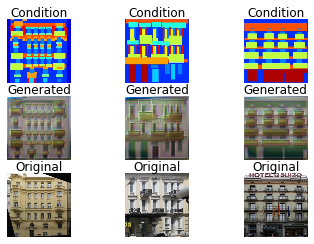

 Epoch: 4/200 | Batch 400/400 | D-loss: 0.0634 | D-acc: 93% | G-loss: 46.318 | time: 0:03:13.052721

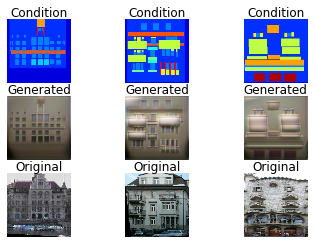

 Epoch: 5/200 | Batch 292/400 | D-loss: 0.0658 | D-acc: 94% | G-loss: 43.997 | time: 0:03:47.119269

In [0]:
import datetime
from PIL import Image
import sys
import matplotlib.pyplot as plt

epochs = 200
batch_size = 1
resize = (256, 256)

os.chdir('/content/drive/My Drive/GitHub Repositories/Generative Models Papers with Implementation in Keras')
baseDir = './Pix2PixGAN-Image-to-Image Translation with Conditional Adversarial Networks'


trainDir = os.path.join(baseDir, 'datasets', 'facades', 'train')
trainImages = os.listdir(trainDir)
batches = int(len(trainImages)/batch_size)

validDir = os.path.join(baseDir, 'datasets', 'facades', 'test')
start_time = datetime.datetime.now()


outputDir = os.path.join(baseDir, 'outputs')
if not os.path.exists(outputDir):
    os.makedirs(outputDir)
    print('Output Directory Created to save Results')
  

# Adversarial loss ground truths
valid = np.ones((batch_size,) + disc_patch)
fake = np.zeros((batch_size,) + disc_patch)

def save_imgs(epoch):
    test_batch = 3
    r, c = 3, 3
    imgs_A = []
    imgs_B = []
    
    for i in range(test_batch):
        pickRandomImage = np.random.choice(os.listdir(validDir), size=batch_size)
        img = np.asarray(Image.open(os.path.join(validDir, ''.join(pickRandomImage))))
        h, w, _ = img.shape
        _w = int(w/2)

        img_A, img_B = img[:, :_w, :], img[:, _w:, :]
        imgs_A.append(img_A)
        imgs_B.append(img_B)
    
    imgs_A = np.array(imgs_A)/127.5 - 1.
    imgs_B = np.array(imgs_B)/127.5 - 1.

    fake_A = G.predict(imgs_B)
    gen_imgs = np.concatenate([imgs_B, fake_A, imgs_A])

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    titles = ['Condition', 'Generated', 'Original']
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt])
            axs[i, j].set_title(titles[i], pad=0.0)
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig(outputDir+'/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()
    plt.close()

for epoch in range(epochs):
    epoch+=1
    for batch in range(batches):
        batch+=1
        # ---------------------
        #  Train Discriminator
        # ---------------------
        imgs_A = []
        imgs_B = []
        pickRandomImage = np.random.choice(trainImages, size=batch_size)
        img = np.array(Image.open(os.path.join(trainDir, ''.join(pickRandomImage))))
        h, w, _= img.shape
        _w = int(w/2)

        img_A, img_B = img[:, :_w, :], img[:, _w:, :]
        # If training => do random flip
        if np.random.random() < 0.5:
            img_A = np.fliplr(img_A)
            img_B = np.fliplr(img_B)

        imgs_A.append(img_A)
        imgs_B.append(img_B)

        imgs_A = np.array(imgs_A)/127.5 - 1.
        imgs_B = np.array(imgs_B)/127.5 - 1.

        # Condition on B and generate a translated version
        fake_A = G.predict(imgs_B)
        # Train the discriminators (original images = real / generated = Fake)
        d_loss_real = D.train_on_batch([imgs_A, imgs_B], valid)
        d_loss_fake = D.train_on_batch([fake_A, imgs_B], fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # -----------------
        #  Train Generator
        # -----------------
        
        g_loss = combined.train_on_batch([imgs_A, imgs_B], [valid, imgs_A])
        elapsed_time = datetime.datetime.now() - start_time
        # Plot the training progress bar
        sys.stdout.write('\r Epoch: {}/{} | Batch {}/{} | D-loss: {:.4f} | D-acc: {:.0f}% | G-loss: {:.3f} | time: {}'.format(epoch, epochs, batch, batches,
                                                                                               d_loss[0], 100*d_loss[1], g_loss[0], elapsed_time))
    # After each epoch save results
    save_imgs(epoch)